# This tutorial shows how to export SG models to ONNX format for deployment to ONNX-compatible runtimes and accelerators.


From this tutorial you will learn:

* How to export Semantic Segmentation model to ONNX and do inference with ONNXRuntime / TensorRT
* How to enable FP16 / INT8 quantization and export a model with calibration
* How to customize confidence threshold parameters for binary segmentation models

## New Export API

A new export API for Object Detection introduced in SG 3.2.0 and since SG 3.7.0 we support `model.export()` for our segmentation models.
It is aimed to simplify the export process and allow end-to-end export of SG models to ONNX format with a single line of code.

### Currently supported models

- All Segformer variants
- All PPLite variants
- All STDC variants
- All DDRNet variants

### Supported features

- Exporting a model with preprocessing (e.g. normalizing/standardizing image according to normalization parameters during training)
- Exporting a model with postprocessing (argmax for multiclass, sigmoid + thresholding for binary) - you obtain the ready-to-use semantic masks
- FP16 / INT8 quantization support with calibration
- Pre- and post-processing steps can be customized by the user if needed
- Customising input image shape and batch size


In [30]:
!pip install -qq super_gradients==3.7.0

### Minimalistic export example

Let start with the most simple example of exporting a model to ONNX format.
We will use YoloNAS-S model in this example. All models that suports new export API now expose a `export()` method that can be used to export a model. There is one mandatory argument that should be passed to the `export()` method - the path to the output file. Currently, only `.onnx` format is supported, but we may add support for CoreML and other formats in the future.

In [31]:
from super_gradients.common.object_names import Models
from super_gradients.training import models

model = models.get(Models.SEGFORMER_B0, pretrained_weights="cityscapes")

export_result = model.export("segformer.onnx")

A lot of work just happened under the hood:

* A model was exported to ONNX format using default batch size of 1 and input image shape that was used during training
* A preprocessing and postprocessing steps were attached to ONNX graph (`preprocessing=True` and `postprocessing=True` are default values for these parameters)
* For pre-processing step, the normalization parameters were extracted from the model itself (to be consistent with the image normalization and channel order used during training)
* A post-processing step was attached to the graph. In case of semantic segmentation models, it includes `argmax` operation to obtain the final segmentation mask.
* ONNX graph was checked and simplified to improve compatibility with ONNX runtimes.

A return value of `export()` method is an instance of `SegmentationModelExportResult` class.
First of all it serves the purpose of storing all the information about the exported model in a single place.
It also provides a convenient way to get an example of running the model and getting the output:

In [32]:
export_result

Model exported successfully to segformer.onnx
Model expects input image of shape [1, 3, 1024, 2048]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ApplyMeanStd(mean=[[[0.485 0.456 0.406]]], scale=[[[0.229 0.224 0.225]]])
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing module SemanticSegmentationDecodingModule().
Output of the model is mask of [(1, 1024, 2048)] [B,H,W] shape with class indices.

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    import matplotlib.pyplot as plt
    from super_gradients.training.utils.visualization.segmentation import overlay_segmentation
    session = onnxruntime.InferenceSessi

That's it. You can now use the exported model with any ONNX-compatible runtime or accelerator.
To show how it works, we will use ONNX Runtime to run the model and visualize the output. 
A helper function `run_inference_with_onnx_model` is provided for this purpose. It loads the model using ONNX Runtime and runs it with a sample image.

In [33]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
from super_gradients.training.utils.media.image import load_image
from super_gradients.training.utils.visualization.segmentation import overlay_segmentation


def run_inference_with_onnx_model(export_result, image: np.ndarray, title):
    image = cv2.resize(image, (export_result.input_image_shape[1], export_result.input_image_shape[0]))
    image_bchw = np.transpose(np.expand_dims(image, 0), (0, 3, 1, 2))

    session = onnxruntime.InferenceSession(export_result.output, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    inputs = [o.name for o in session.get_inputs()]
    outputs = [o.name for o in session.get_outputs()]
    predictions = session.run(outputs, {inputs[0]: image_bchw})
    
    [segmentation_mask] = predictions
    
    overlay = overlay_segmentation(
        pred_mask=segmentation_mask[0], image=image, num_classes=19, alpha=0.5
    )
    f = plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(title)
    plt.tight_layout()
    plt.show()

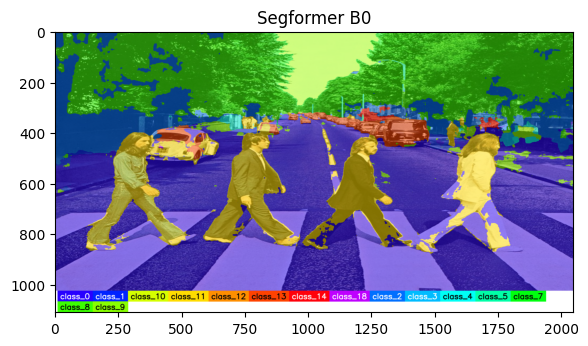

In [34]:
image = load_image("https://deci-pretrained-models.s3.amazonaws.com/sample_images/beatles-abbeyroad.jpg")
run_inference_with_onnx_model(export_result, image, title='Segformer B0')

Please note that we are using the smallest model variant in this example. 
It is not very accurate and the result is not perfect which is fine - the goal of this notebook is to demonstrate the concepts.
You can use larger models for better results.

In the snippet above we resize the input image to the shape that was used during training - `(1024, 2048)` and run the model using ONNX Runtime. It is very easy to change the image resolution to your needs. All you need is to specify `input_image_shape` parameter when calling `export()` method:


In [35]:
export_result = model.export("segformer_640_640.onnx", input_image_shape=(640,640))

If we now run the model with the same image, we will see that the output resolution is different:

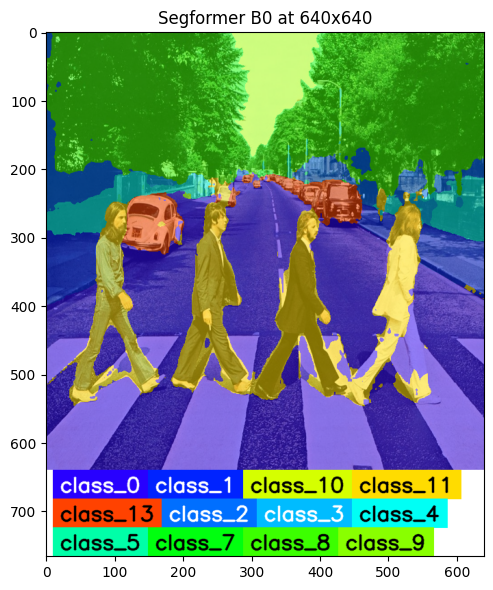

In [36]:
run_inference_with_onnx_model(export_result, image, title='Segformer B0 at 640x640')

### Export of quantized model

You can export a model with quantization to FP16 or INT8. To do so, you need to specify the `quantization_mode` argument of `export()` method.

Important notes:
* Quantization to FP16 requires CUDA / MPS device available and would not work on CPU-only machines.

Let's see how it works:

In [37]:
!pip install pytorch-quantization==2.1.2 --extra-index-url https://pypi.ngc.nvidia.com

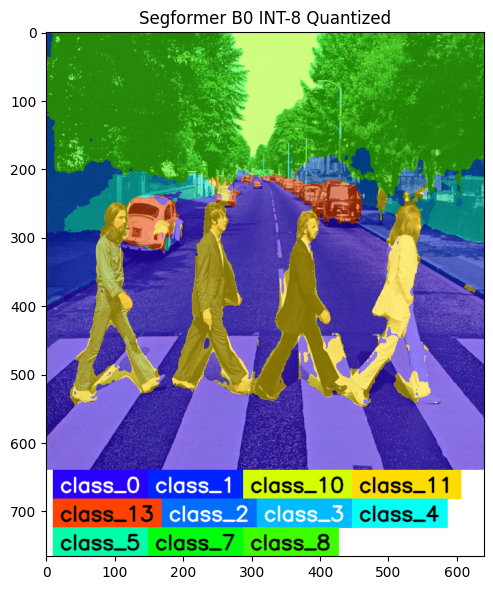

In [38]:
from super_gradients.conversion.conversion_enums import ExportQuantizationMode

export_result = model.export(
    "segformer_b0_int8.onnx",
    input_image_shape=(640, 640),
    quantization_mode=ExportQuantizationMode.INT8 # or ExportQuantizationMode.FP16
)

run_inference_with_onnx_model(export_result, image, title='Segformer B0 INT-8 Quantized')

### Advanced INT-8 quantization options

When quantizing a model using `quantization_mode==ExportQuantizationMode.INT8` you can pass a DataLoader to export() function to collect correct statistics of activations to prodice a more accurate quantized model.
We expect the DataLoader to return either a tuple of tensors or a single tensor. In case a tuple of tensors is returned by data-loader the first element will be used as input image.
You can use existing data-loaders from SG here as is.

**Important notes**
* A `calibration_loader` should use same image normalization parameters that were used during training.

In the example below we use a dummy data-loader for sake of showing how to use this feature. You should use your own data-loader here.

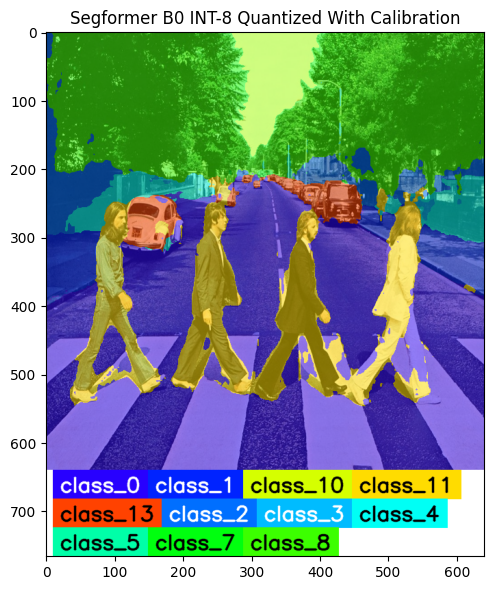

In [39]:
import torch
from torch.utils.data import DataLoader
from super_gradients.conversion import ExportQuantizationMode

# THIS IS ONLY AN EXAMPLE. YOU SHOULD USE YOUR OWN DATA-LOADER HERE
dummy_calibration_dataset = [torch.randn((3, 640, 640), dtype=torch.float32) for _ in range(32)]
dummy_calibration_loader = DataLoader(dummy_calibration_dataset, batch_size=8, num_workers=0)
# THIS IS ONLY AN EXAMPLE. YOU SHOULD USE YOUR OWN DATA-LOADER HERE

export_result = model.export(
    "segformer_b0_int8_calibrated.onnx",
    input_image_shape=(640, 640),
    quantization_mode=ExportQuantizationMode.INT8 # or ExportQuantizationMode.FP16
)

run_inference_with_onnx_model(export_result, image, title='Segformer B0 INT-8 Quantized With Calibration')

### Limitations

* Dynamic batch size / input image shape is not supported yet. You can only export a model with a fixed batch size and input image shape.
* TensorRT of version 8.4.1 or higher is required.
* Quantization to FP16 requires CUDA / MPS device available.